In [1]:
# Imports
import torch
import math

In [2]:
#switching off autograd globally
torch.set_grad_enabled(False)

# 1. Modules

## Baseclass

In [3]:
class Module(object):
    """
    Base class for all modules.
    """

    def forward(self, input_):
        """
        Function to get the input, apply forward pass of module and
        returns a tensor or a tuple of tensors..
        """
        raise NotImplementedError

    def backward(self, gradswrtoutput):
        """
        Function to get input the gradient of the loss with respect to the
        module’s output, accumulate the gradient wrt the parameters, and
        return a tensor or a tuple of tensors containing the gradient of
        the loss wrt the module’s input.
        """
        raise NotImplementedError

    def param(self):
        """
        Returns a list of pairs, each composed of a parameter tensor, and
        a gradient tensor of same size.
        """
        return []

    def zero_grad(self):
        """
        Sets the gradients of a module to 0
        """
        return []

## Activation Functions

### TanH

In [4]:
class TanH(Module):
    """Module to apply the hyperbolic tangent function"""

    def __init__(self):
        super().__init__()

    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        """Returns the tensor after applying tanh to the input and saves the
        input to help in backward pass computation.

        Parameters:
            input (Tensor): The tensor on which the tanh should be applied

        Returns:
            Tensor: The tensor obtained after applying the tanh on the input
        """
        self.inp = input_
        self.out_ = self.inp.tanh()
        return self.out_

    def backward(self, gradwrtoutput: torch.Tensor) -> torch.Tensor:
        """
        Returns the gradient of loss with respect to the input on applying tanh

        Parameters:
            gradientwrtoutput (Tensor): gradient with respect to the output

        Returns:
            Tensor: The gradient of the loss with respect to the input
        """
        return gradwrtoutput * (1 - self.out_.pow(2))

    def param(self):
        return []

### ReLU

In [5]:
class ReLU(Module):
    """Module to apply the Rectified Linear function"""

    def __init__(self):
        super().__init__()

    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        """Returns the tensor after applying ReLU to the input and saves the
        input to help in backward pass computation.

        Parameters:
            input (Tensor): The tensor on which the ReLU should be applied

        Returns:
            Tensor: The tensor obtained after applying the ReLU on the input
        """
        self.inp = input_
        self.out = self.inp.clamp(min=0.0)
        return self.out

    def backward(self, gradwrtoutput: torch.Tensor) -> torch.Tensor:
        """
        Returns the gradient of loss with respect to the input on applying ReLU

        Parameters:
            gradientwrtoutput (Tensor): gradient with respect to the output

        Returns:
            Tensor: The gradient of the loss with respect to the input
        """
        self.out[self.out < 0 ]  = 0
        self.out[self.out > 0 ]  = 1
        return gradwrtoutput * self.out

    def param(self):
        return []

### Sigmoid

In [6]:
# did not require in the assignment

class Sigmoid(Module):
    """Module to apply the Sigmoid function"""

    def __init__(self):
        super().__init__()

    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        """Returns the tensor after applying sigmoid to the input and saves the
        input to help in backward pass computation.

        Parameters:
            input (Tensor): The tensor on which the sigmoid should be applied

        Returns:
            Tensor: The tensor obtained after applying the sigmoid on the input
        """
        self.inp = input_
        self.out_ = self.inp.sigmoid()
        return self.out_

    def backward(self, gradwrtoutput: torch.Tensor) -> torch.Tensor:
        """
        Returns the gradient of loss with respect to the input on applying sigmoid

        Parameters:
            gradientwrtoutput (Tensor): gradient with respect to the output

        Returns:
            Tensor: The gradient of the loss with respect to the input
        """
        return gradwrtoutput * (self.out_ - self.out_**2)

    def param(self):
        return []

## Losses

### MSE

In [7]:
class MSELoss(Module):
    """Module to calculate the Mean Squared Error."""

    def __init__(self):
        super().__init__()

    def forward(self, input_: torch.Tensor,
                target: torch.Tensor) -> torch.Tensor:
        """Returns the MSE Loss between input_ and target

        Parameters:
            input_ (Tensor): First tensor to calculate the MSE.
            target (Tensor): Second tensor to calculate the MSE.

        Returns:
            Tensor: The Mean Squared Loss between input_ and target
            """
        self.error = input_ - target
        self.loss = self.error.pow(2).mean()
        return self.loss

    def backward(self, gradswrtoutput=1):
        """
        gradient of loss
        """
        return (gradswrtoutput * 2 * self.error)/self.error.size()[0]

## Optimizer

In [8]:
class Optimizer(object):
    """
    Base class for optimzers.
    """

    def step(self):
        raise NotImplementedError

### SGD

In [9]:
class SGD(Optimizer):
    """
    Module to perform Stochastic Gradient Descent
    """

    def __init__(self, params, lr=0.01):
        super().__init__()

        self.params = params
        self.lr = lr

    def step(self):
        """
        Function to perform the single optimization step

        Parameters
            params (list): List of the paramerters of the network
            lr (float): The learning rate of the network
        """

        for weight, gradient in self.params:
            if (weight is None) or (gradient is None):
                # incase of activation function modules, skip them
                continue
            else:
                weight.add_(-self.lr*gradient)

## Layers

### Linear 

In [10]:
class Linear(Module):
    """
    Module that implements as linear maxtrix operation layer
    """

    def __init__(self, in_features, out_features, bias=True):
        """
        Initialises the layer by creating empty weight and bias tensors
        and Initialising them using Normal distribution.
        """
        super().__init__()

        self.in_features, self.out_features = in_features, out_features

        self.w = torch.empty(self.in_features, self.out_features)
        self.gradw = torch.empty(self.in_features, self.out_features)

        if bias:
            self.b = torch.empty(self.out_features)
            self.gradb = torch.empty(self.out_features)
        else:
            self.b = None
            self.gradb = None

        self.initWeights()

    def initWeights(self):
        """
        Initialises the weight and bias parameters of the layer.
        """

        self.w.normal_()
        self.gradw.fill_(0)

        if self.b is not None:
            self.b.normal_()
            self.gradb.fill_(0)

    def forward(self, input_):
        """
        Computes the forward pass of the layer by multiplying the input with weights and adding the bias
        """

        self.inp = input_

        if self.b is None:
            self.output = self.inp.matmul(self.w)
        else:
            self.output = self.inp.matmul(self.w).add(self.b)

        return self.output

    def backward(self, gradwrtoutput):
        """
        computes the gradient the weights and biases.
        """

        gradw = self.inp.t().matmul(gradwrtoutput)
        self.gradw.add_(gradw)

        if self.b is not None:
            gradb = gradwrtoutput.sum(0)
            self.gradb.add_(gradb)
        gradient = gradwrtoutput.matmul(self.w.t())
        return gradient

    def param(self):
        """
        Return the paramerters of the layer
        """

        params = [(self.w, self.gradw)]
        if self.b is not None:
            params.append((self.b, self.gradb))
        return params

    def zero_grad(self):
        """
        Sets the gradient to zero
        """

        self.gradw.zero_()

        if self.b is not None:
            self.gradb.zero_()

### Sequential

In [11]:
class Sequential(Module):
    """
    Module to hold the layers and build the Network
    """

    def __init__(self, *args):
        super().__init__()

        # A list to hold all layers of the network
        self.modules = [module for module in args]

    def forward(self, input_):
        """
        DOCSTRING TBD
        """
        self.inp = input_
        # incase of no layers, the input itself is returned as output
        output = input_

        for module in self.modules:
            output = module.forward(output)

        self.output = output

        return self.output

    def backward(self, gradwrtoutput):
        """
        DOCSTRING TBD
        """
        # The error is propagated in the reverse (backward) direction
        for module in reversed(self.modules):
            gradwrtoutput = module.backward(gradwrtoutput)

        self.grad = gradwrtoutput

        return self.grad

    def param(self):
        """
        List of parameters of all modules
        """

        params = []
        for module in self.modules:
            params.extend(module.param())

        return params

    def zero_grad(self):
        """
        Sets the gradient to zero of all modules
        """

        for weight, gradient in self.param():
            if (weight is None) or (gradient is None):
                # incase of activation function modules, skip them
                continue
            else:
                gradient.zero_()

# 2. Data generation

In [12]:
def generate_data(num_points):
    """
    Common function to generate the dataset of 1,000 points sampled uniformly
    in [0, 1]^2, each with a label 0 if outside the disk centered at (0.5; 0.5)
    of radius 1/sqrt(2*pi), and 1 inside.

    Parameters:
        num_points (int): The number of points to be generated

    Returns:
        Tensor : A two dimensional input data with points sampled between [0,1]
        Tensor : A two dimensional output data that contains labels
        corresponding to the input data generated above as one hot encoded variable
    """

    input_ = torch.Tensor(num_points, 2).uniform_(0, 1)

    labels = input_.sub(0.5).pow(2).sum(1).sub(1 / (2 * math.pi)).sign().add(1).div(2).long()

    labels_onehot = torch.empty(num_points, 2).fill_(0)
    labels_onehot[:, 0] = labels == 0
    labels_onehot[:, 1] = labels == 1

    return input_, labels_onehot

# 3. Train Model

In [13]:
def train_model(model, train_input, train_target, loss_criteria, learning_rate,
                mini_batch_size, nb_epochs):

    optimizer = SGD(model.param(), lr=learning_rate)
    losses = []
    for epoch_number in range(nb_epochs):
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model.forward(train_input.narrow(0, b, mini_batch_size))
            loss_ = loss_criteria.forward(output, train_target.narrow(0, b, mini_batch_size))
            model.zero_grad()
            model.backward(loss_criteria.backward())
            optimizer.step()
        if epoch_number % 100 == 0:
            print("Epoch {} Training loss {} ". format(epoch_number, loss_.item()))
        losses.append(loss_.item())
    return losses


def compute_nb_errors(model, input_, target):
    '''
    Computes and returns the number of prediction mistakes
    '''
    nb_data_errors = 0

    output = model.forward(input_)

    _, predicted = torch.max(output.data, 1)

    _, actual = torch.max(target.data, 1)

    for k in range(input_.size()[0]):
        if actual.data[k] != predicted[k]:
            nb_data_errors = nb_data_errors + 1
    return nb_data_errors

In [14]:
train_input, train_target = generate_data(1000)
test_input, test_target = generate_data(200)

mu, std = train_input.mean(), train_input.std()
train_input.sub_(mu).div_(std)
test_input.sub_(mu).div_(std)

tensor([[ 1.0084, -0.1382],
        [ 1.0279,  0.5660],
        [-1.0160,  1.6597],
        [-0.2534, -0.0853],
        [-1.4146,  0.7649],
        [-0.8255,  1.2179],
        [-0.2828,  1.5426],
        [ 1.2773,  1.1569],
        [ 1.3914,  1.0999],
        [-0.1954, -1.4017],
        [ 1.4385, -0.3401],
        [ 1.5906,  1.5709],
        [-0.4735,  0.5988],
        [ 0.6824,  0.8362],
        [ 1.1471,  1.7393],
        [-1.1745, -0.9665],
        [-1.1113, -0.0538],
        [-0.9959, -1.2350],
        [ 0.3377,  1.1353],
        [ 0.5902, -0.5585],
        [ 0.0652, -0.6855],
        [ 0.6994,  0.0552],
        [ 0.6899,  0.8159],
        [ 0.2197,  0.7576],
        [-0.6487, -1.6435],
        [ 0.3561, -0.1901],
        [ 0.1724, -0.0430],
        [-0.8153,  0.4746],
        [-1.2103, -0.9335],
        [ 0.5604,  1.6939],
        [ 0.3806, -0.0227],
        [-0.2334,  1.2296],
        [ 0.6450, -1.1669],
        [-1.2468,  0.7892],
        [-0.5457,  0.1966],
        [ 0.9234, -0

In [15]:
Model_1 = Sequential(Linear(2, 25), TanH(),
                     Linear(25, 25), TanH(),
                     Linear(25, 25), TanH(),
                     Linear(25, 25), TanH(),
                     Linear(25, 2), Sigmoid())

Model_2 = Sequential(Linear(2, 25), ReLU(),
                     Linear(25, 25), ReLU(),
                     Linear(25, 25), ReLU(),
                     Linear(25, 25), ReLU(),
                     Linear(25, 2), Sigmoid())

In [16]:
learning_rate = 0.01
nb_epochs = 1000
model_loss = []
mini_batch_size = 200
for i, M in enumerate([Model_1, Model_2]):
    loss_fnc = MSELoss()
    print('Model', i+1)

    model_loss.append(train_model(M, train_input, train_target, loss_fnc, learning_rate, mini_batch_size, nb_epochs))

    nb_train_errors = compute_nb_errors(M, train_input, train_target)
    nb_test_errors = compute_nb_errors(M, test_input, test_target)

    print('Train Accuracy {:0.2f}% {:d}/{:d}'.format((100 * (train_input.size(0)-nb_train_errors)) / train_input.size(0),
                                                     (train_input.size(0) - nb_train_errors), train_input.size(0)))

    print('Test Accuracy {:0.2f}% {:d}/{:d}'.format((100 * (test_input.size(0) - nb_test_errors)) / test_input.size(0),
                                                    (test_input.size(0) - nb_test_errors), test_input.size(0)))
    
    print('Train Error {:0.2f}% {:d}/{:d}'.format((100 * (nb_train_errors)) / train_input.size(0),
                                                     (train_input.size(0) - nb_train_errors), train_input.size(0)))

    print('Test Error {:0.2f}% {:d}/{:d}'.format((100 * (nb_test_errors)) / test_input.size(0),
                                                    (nb_test_errors), test_input.size(0)))
    
    print("\n")

Model 1
Epoch 0 Training loss 0.3733569383621216 
Epoch 100 Training loss 0.19858893752098083 
Epoch 200 Training loss 0.1228412613272667 
Epoch 300 Training loss 0.06333176791667938 
Epoch 400 Training loss 0.039705824106931686 
Epoch 500 Training loss 0.03125762566924095 
Epoch 600 Training loss 0.02532937377691269 
Epoch 700 Training loss 0.020313816145062447 
Epoch 800 Training loss 0.01774614490568638 
Epoch 900 Training loss 0.01597529835999012 
Train Accuracy 99.00% 990/1000
Test Accuracy 99.00% 198/200
Train Error 1.00% 990/1000
Test Error 1.00% 2/200


Model 2
Epoch 0 Training loss 0.5042600035667419 
Epoch 100 Training loss 0.48176339268684387 
Epoch 200 Training loss 0.48003074526786804 
Epoch 300 Training loss 0.35738566517829895 
Epoch 400 Training loss 0.3452419340610504 
Epoch 500 Training loss 0.3294805884361267 
Epoch 600 Training loss 0.31494423747062683 
Epoch 700 Training loss 0.3131677210330963 
Epoch 800 Training loss 0.2990536093711853 
Epoch 900 Training loss 0.

# 4. Plotting Loss

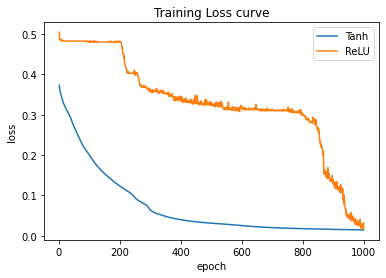

In [17]:
import matplotlib.pyplot as plt

epochs = torch.arange(1,nb_epochs+1)
plt.plot(epochs, model_loss[0], label = 'Tanh')
plt.plot(epochs, model_loss[1], label = 'ReLU')
plt.title("Training Loss curve")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()